In [1]:
from __future__ import annotations
from abc        import ABC, abstractmethod
from typing     import List

import sys
sys.path.insert(0, '../../..')

import warnings
warnings.filterwarnings("ignore")
import joblib
import requests
import configparser
import asyncio
from binance.client import Client as BinanceClient
from binance.client import AsyncClient
from binance        import BinanceSocketManager
import pandas as pd
import numpy  as np

from ta import momentum, trend, volatility
from ta import volume as tavolume

import mlfinlab as fml

from cgi import test
from multiprocessing.sharedctypes import Value
from yaml import parse
import glob
import warnings
import requests
import dateutil
import pytz
import traceback
import pandas            as pd
import pandas_ta         as ta
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import mlfinlab          as fml
from   mlfinlab          import sample_weights
import pyfolio           as pf
from scipy.stats         import norm
from backtesting         import Backtest, Strategy
from backtesting.lib     import crossover

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,12)

In [2]:
df = pd.read_csv("/home/sharav/src/binance-history-downloader/data/klines/BTCUSDT-1m-spot.csv", parse_dates=True, index_col="timestamp")

df

,Open,High,Low,Close,Volume
timestamp,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2023-02-28 23:55:00,23124.18,23125.40,23112.33,23116.25,157.814340
2023-02-28 23:56:00,23115.30,23122.93,23112.64,23121.22,66.582270
2023-02-28 23:57:00,23121.73,23137.39,23117.41,23121.42,165.619490


In [3]:
def get_daily_volatility(close, lookback=100):
    # daily vol re-indexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
    df0 = close.loc[df0.index] / close.loc[df0.array].array - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

In [4]:
class MLInterface:
    def __init__(self):
        self.primary_threshold = 0.65

        self.side_features = []
        self.meta_features = []
        with open("../../../asset_btcusdt/meta-ml/model/features_side.txt", "r") as f:
            self.side_features = f.readlines()[0].strip().split()
        with open("../../../asset_btcusdt/meta-ml/model/features_meta.txt", "r") as f:
            self.meta_features = f.readlines()[0].strip().split()
        print(f"side features : {self.side_features}")
        print(f"meta features : {self.meta_features}")
        self.side_rf = joblib.load("../../../asset_btcusdt/meta-ml/model/btcusdt_rf_side.save")
        self.meta_rf = joblib.load("../../../asset_btcusdt/meta-ml/model/btcusdt_rf_meta.save")
        print(self.side_rf)
        print(self.meta_rf)

    def do_inference(self, df):
        df["volatility_tpsl"] = get_daily_volatility(close=df['Close'], lookback=600)

        # primary features : ['ma_440', 'daily_volatility_30', 'vm_eom_25', 'vl_atr_180', 'vm_cmf_180']
        df["sma_440"            ] = trend.sma_indicator(df['Close'], window=440)
        df["ma_440"             ] = df['Close']/df[f"sma_440"]-1.0
        df["daily_volatility_30"] = fml.util.get_daily_vol(close=df['Close'], lookback = 30)
        df["vm_eom_25"          ] = tavolume.ease_of_movement(df['High'], df['Low'], df['Volume'], window=25)
        df["vl_atr_180"         ] = volatility.average_true_range(df['High'], df['Low'], df['Close'], window=180)
        df["vm_cmf_180"         ] = tavolume.chaikin_money_flow(df['High'], df['Low'], df['Close'], df['Volume'], window=180)
        # meta features : ['vl_bbp', 't_adx_90', 'close_plus_minus_40']
        df["vl_bbp"             ] = volatility.bollinger_pband(df['Close'])
        df["t_adx_90"           ] = trend.adx(df['High'], df['Low'], df['Close'], window=90)
        df["momentum_1"         ] = df['Close'].pct_change(periods=1)
        df["close_sign"         ] = df['momentum_1'].apply(np.sign)
        df["close_plus_minus_40"] = df['close_sign'].rolling(40).apply(lambda x: x.sum())

        df = df.fillna(0.0)

        df['side'] = self.side_rf.predict(df[self.side_features]) 
        df.loc[df['side']==-1, 'prob'] = self.side_rf.predict_proba(df[df['side']==-1][self.side_features])[:,0]
        df.loc[df['side']== 1, 'prob'] = self.side_rf.predict_proba(df[df['side']== 1][self.side_features])[:,1]
        df['is_signal'] = False
        df.loc[(df['prob']>=self.primary_threshold)|(df['prob']>=self.primary_threshold), 'is_signal'] = True

        signal_indexes = df[df['is_signal']==True].index
        df['act'] = 0
        df.loc[signal_indexes, 'act'     ] = self.meta_rf.predict(df.loc[signal_indexes][self.meta_features])
        df.loc[signal_indexes, 'act_prob'] = self.meta_rf.predict_proba(df.loc[signal_indexes][self.meta_features])[:,1]

        return df

In [5]:
ml_inference = MLInterface()

side features : ['ma_440', 'daily_volatility_30', 'vm_eom_25', 'vl_atr_180', 'vm_cmf_180']
meta features : ['vl_bbp', 't_adx_90', 'close_plus_minus_40']
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=30, n_estimators=512, n_jobs=-1,
                       random_state=42)
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=30, n_estimators=512, n_jobs=-1,
                       random_state=42)


In [6]:
df = ml_inference.do_inference(df)

df

,Open,High,Low,Close,Volume,volatility_tpsl,sma_440,ma_440,daily_volatility_30,vm_eom_25,...,vl_bbp,t_adx_90,momentum_1,close_sign,close_plus_minus_40,side,prob,is_signal,act,act_prob
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.0,0.0,-1.0,0.566406,False,0,NaN
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.0,0.0,-1.0,0.566406,False,0,NaN
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.004477,1.0,0.0,-1.0,0.566406,False,0,NaN
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,0.000000,0.000000,0.000000,0.000000,-0.000000e+00,...,0.000000,0.000000,-0.004457,-1.0,0.0,-1.0,0.566406,False,0,NaN
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.0,0.0,-1.0,0.566406,False,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,23124.18,23125.40,23112.33,23116.25,157.814340,0.008328,23309.565932,-0.008293,0.001386,-8.381266e+07,...,-0.027707,13.958657,-0.000343,-1.0,-2.0,1.0,0.602669,False,0,NaN
2023-02-28 23:56:00,23115.30,23122.93,23112.64,23121.22,66.582270,0.008342,23308.785341,-0.008047,0.001358,-1.669093e+07,...,0.118305,13.927030,0.000215,1.0,-2.0,1.0,0.604077,False,0,NaN
2023-02-28 23:57:00,23121.73,23137.39,23117.41,23121.42,165.619490,0.008356,23307.974000,-0.008004,0.001339,1.159934e+08,...,0.142375,13.873442,0.000009,1.0,-2.0,1.0,0.658882,True,1,0.500595


In [7]:
df['is_signal'].value_counts()

False    2484474
True      418485
Name: is_signal, dtype: int64

In [8]:
df['position'] = df['side']

In [9]:
# Model performance evaluation on OOS data

from backtesting     import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.lib import resample_apply

def SMA(array, n):
    return pd.Series(array).rolling(n).mean()

def kelly(prob_win, payout_perc):
    return (prob_win * payout_perc - (1 - prob_win)) / payout_perc


binance_commission = 0.0004  # Taker Fee rate is 0.04%

RR         = 2.0
sl_target  = 1.0
long_ptsl  = [round(sl_target*RR, 2), sl_target]
short_ptsl = [round(sl_target*RR, 2), sl_target]

In [10]:
act_threshold = 0.55
act_ceil      = 0.6

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        act_prob        = self.data.act_prob[-1]

        size=0.1
        if act_prob>=act_threshold and act_prob<=act_ceil:
            size = 0.5
        if act_prob>act_ceil:
            size = 1.0

        if position==1 and act_prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and act_prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    df["2022-01-16":], 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()

stats

Start                     2022-01-16 00:00:00
End                       2023-02-28 23:59:00
Duration                    408 days 23:59:00
Exposure Time [%]                    95.44621
Equity Final [$]             106704741.824176
Equity Peak [$]              115892086.974439
Return [%]                           6.704742
Buy & Hold Return [%]                  -46.27
Return (Ann.) [%]                    6.370834
Volatility (Ann.) [%]               16.516075
Sharpe Ratio                         0.385735
Sortino Ratio                        0.666883
Calmar Ratio                         0.396865
Max. Drawdown [%]                  -16.052908
Avg. Drawdown [%]                   -0.479034
Max. Drawdown Duration      247 days 09:54:00
Avg. Drawdown Duration        3 days 07:08:00
# Trades                                  899
Win Rate [%]                        37.152392
Best Trade [%]                      11.523675
Worst Trade [%]                     -6.143393
Avg. Trade [%]                    

Start date,2022-01-16
End date,2023-02-28
Total months,42
,Backtest
Annual return,30.0%
Cumulative returns,155.2%
Annual volatility,34.0%
Sharpe ratio,0.94
Calmar ratio,1.08
Stability,0.94
Max drawdown,-27.7%


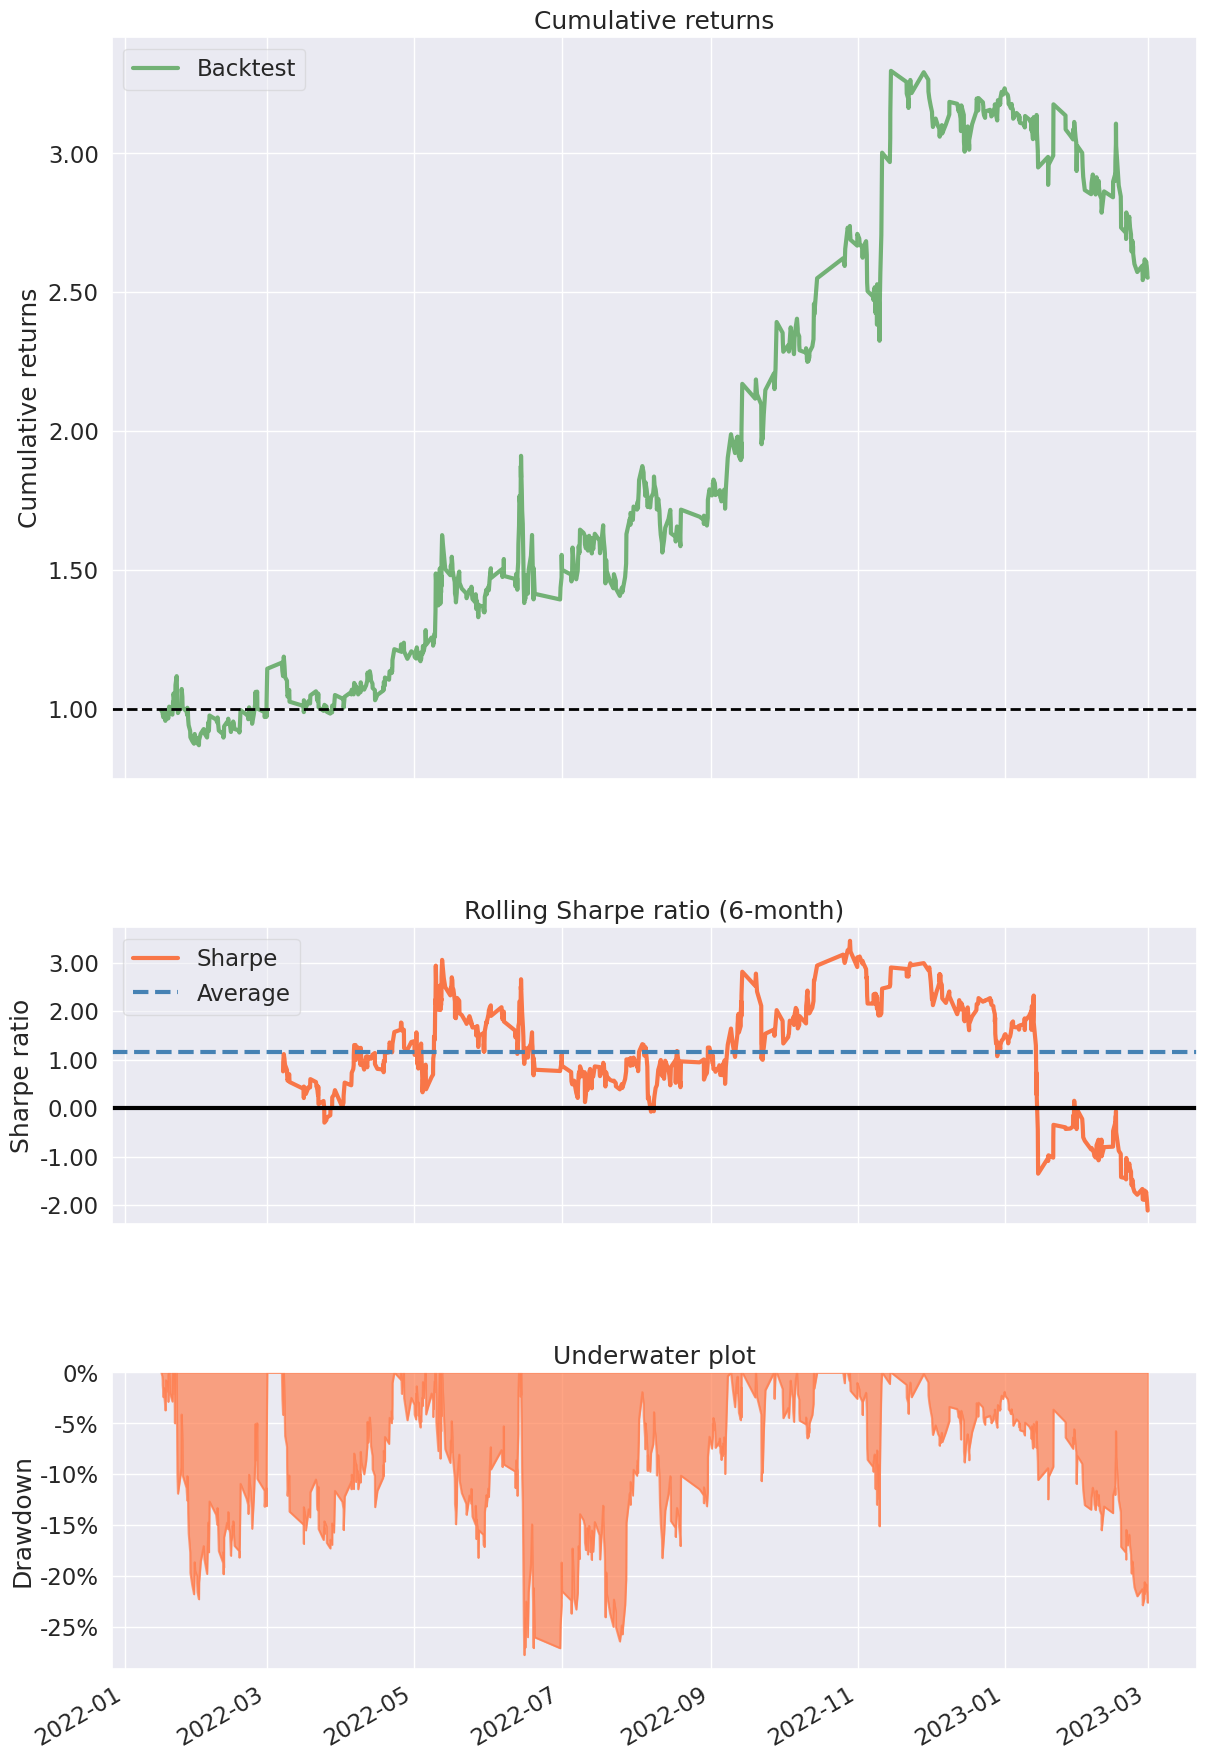

In [11]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [14]:
act_threshold = 0.55
act_ceil      = 0.65

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]
        position        = self.data.position[-1]
        act_prob        = self.data.act_prob[-1]

        size=0.1
        if act_prob>=act_threshold and act_prob<=act_ceil:
            size = 0.5
        if act_prob>act_ceil:
            size = 1.0

        if position==1 and act_prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and act_prob>=act_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    df["2022-01-16":], 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()

stats

Start                     2022-01-16 00:00:00
End                       2023-02-28 23:59:00
Duration                    408 days 23:59:00
Exposure Time [%]                    95.44621
Equity Final [$]             111649197.410066
Equity Peak [$]               123064011.73643
Return [%]                          11.649197
Buy & Hold Return [%]                  -46.27
Return (Ann.) [%]                   10.758779
Volatility (Ann.) [%]               24.650153
Sharpe Ratio                         0.436459
Sortino Ratio                        0.781696
Calmar Ratio                         0.573781
Max. Drawdown [%]                   -18.75067
Avg. Drawdown [%]                     -0.3899
Max. Drawdown Duration      167 days 23:45:00
Avg. Drawdown Duration        1 days 17:13:00
# Trades                                  899
Win Rate [%]                        37.152392
Best Trade [%]                      11.523675
Worst Trade [%]                     -6.143393
Avg. Trade [%]                    

Start date,2022-01-16
End date,2023-02-28
Total months,42
,Backtest
Annual return,30.0%
Cumulative returns,155.2%
Annual volatility,34.0%
Sharpe ratio,0.94
Calmar ratio,1.08
Stability,0.94
Max drawdown,-27.7%


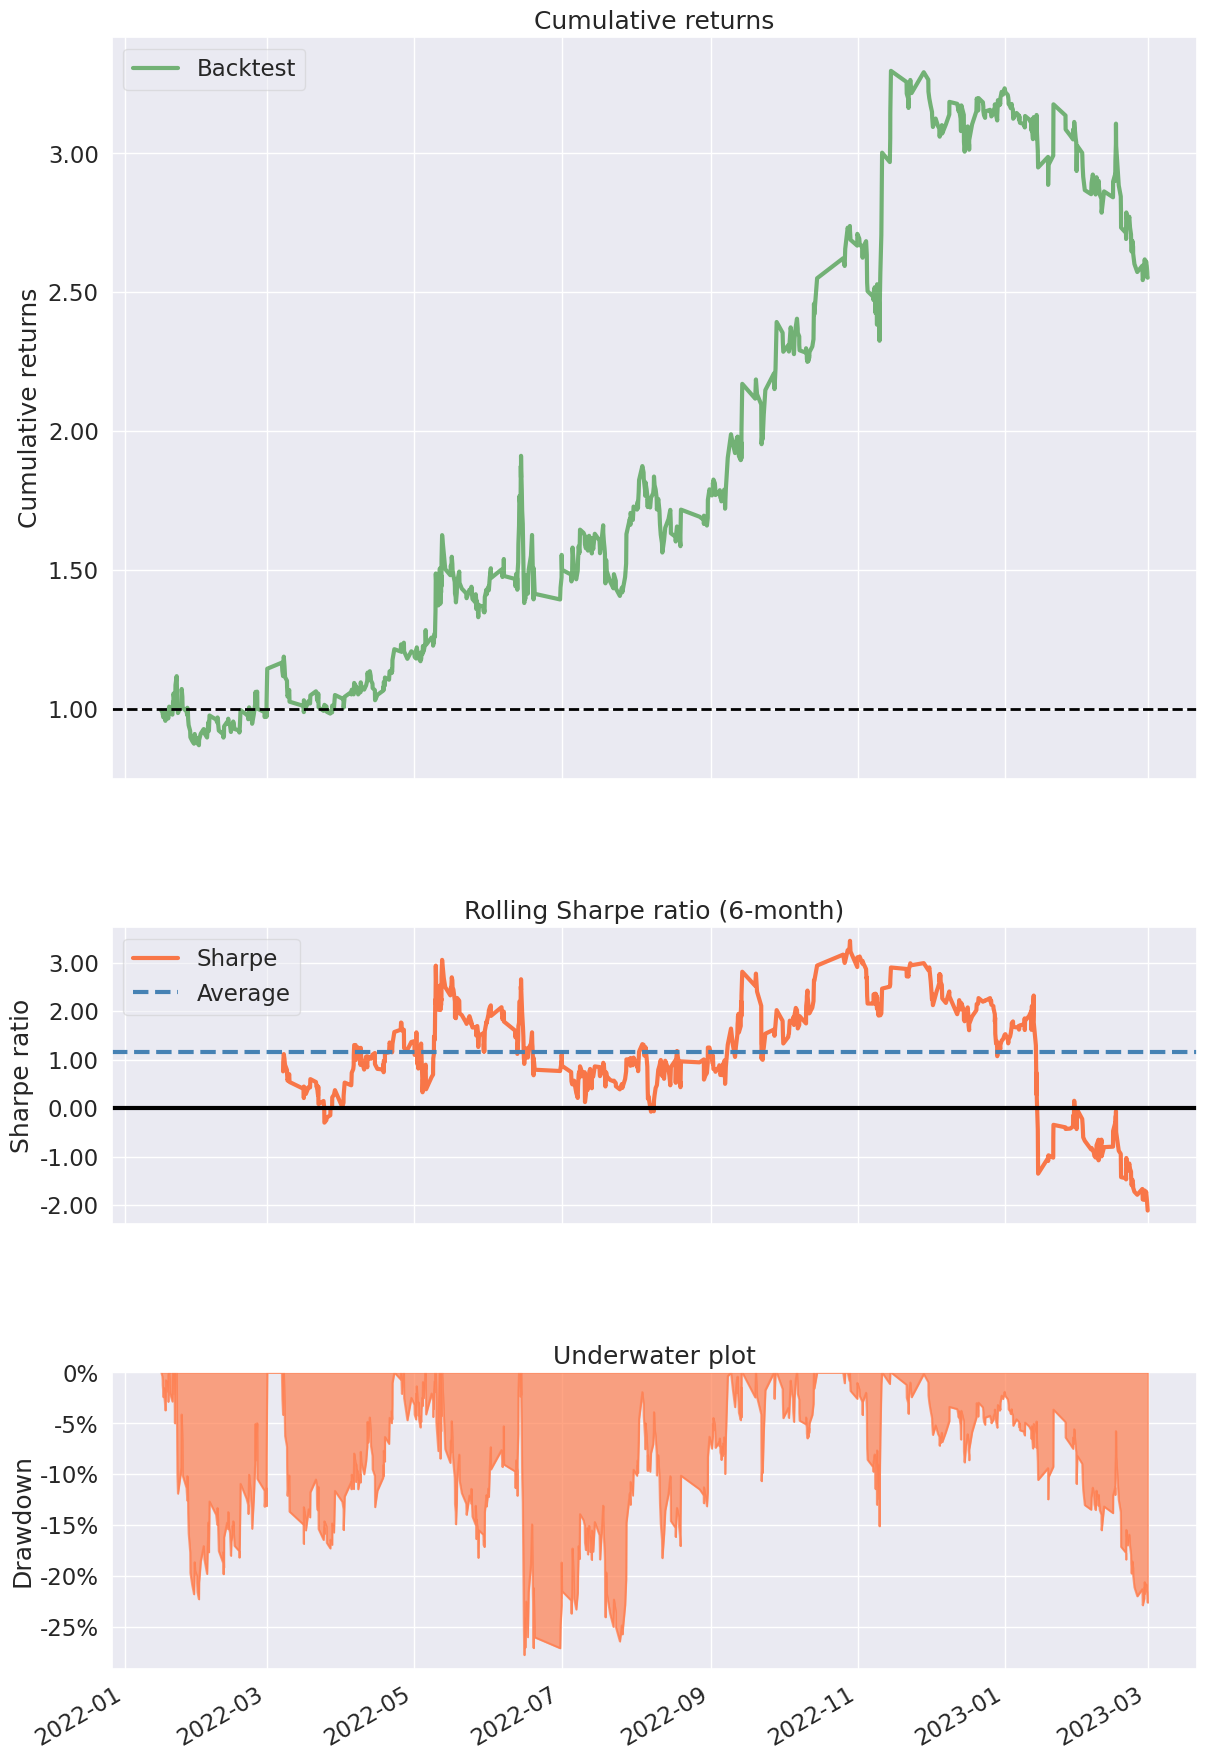

In [15]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])